엣지
- 이미지에서 밝기가 갑자기 변하는 부분을 나타냅니다. 이것은 주로 객체나 패턴의 경계를 나타내며, 이미지에서 구조적인 정보를 얻는 데 중요한 역할을 합니다. 엣지 검출은 이미지 처리에서 매우 중요한 단계로, 객체 인식, 영상 분할, 영상 복원 등 다양한 응용 분야에서 사용

cv2.findContours() 함수
- 입력 이미지에서 컨투어를 찾는다.
- edged.copy()는 엣지 감지된 이미지를 사용.
- cv2.RETR_EXTERNAL은 가장 바깥쪽의 컨투어만을 찾겠다는 옵션.
- cv2.CHAIN_APPROX_SIMPLE은 컨투어의 근사화 방법을 설정.
- 이 함수는 찾은 컨투어와 컨투어의 계층 구조를 반환.


## Install the necessary packages

In [1]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-kor
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 3s (1,826 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

### Import Packages

In [2]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

### Function to display images in Jupyter Notebooks and Google Colab
Colab에서 이미지를 확인하기위한 Function

In [3]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
# title이 리스트인 경우 각 이미지에 대한 제목으로 사용하고, 그렇지 않은 경우 모든 이미지에 같은 제목을 사용
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

### Load Image

In [4]:
url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

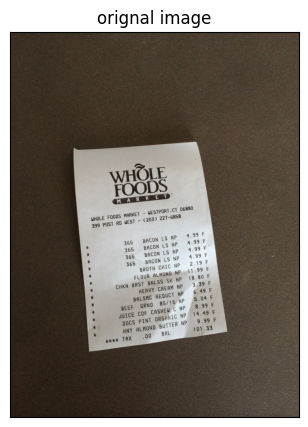

In [ ]:
plt_imshow("orignal image", org_image)

Q. 입력된 이미지를 전처리 과정을 통해 Scan한 이미지로 변경하는 과정에 다음 사항을 모두 포함하는 사용자 함수 make_scan_image를 작성하세요.
- 'gray', 'blurred', 'edged'이미지에다가 outline도 추가
- 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정, 네 개의 점을 입력으로 받아 원근 변환을 수행하고, 변환된 이미지를 반환하는 transform_image도 추가
- 사용자함수의 반환값은 transform_image

In [5]:
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []

  org_image = image.copy()
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])

  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold) # cv2.Canny() 함수를 사용하여 블러 처리된 이미지에서 엣지를 검출

  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]

  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

  findCnt = None

  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  # cv2.arcLength() 함수를 사용하여 컨투어의 둘레를 계산. c는 컨투어를 True는 컨투어가 닫혀있는지 여부를 지정
  # cv2.approxPolyDP() 함수를 사용하여 컨투어를 근사화.c는 근사화할 컨투어. 0.02 * peri는 근사화 정밀도를 결정하는 값.
  # 둘레의 2% 만큼의 정밀도를 가지고 근사화를 수행
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break


  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))


  output = image.copy()
  # output 이미지에 findCnt 변수에 저장된 컨투어를 모두 녹색으로 두껍게 그리는 역할
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2) # -1은 모든 컨투어를 그리라는 의미
  # outline 추가
  image_list_title.append("Outline")
  image_list.append(output)

  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정. 네 개의 점을 입력으로 받아 원근 변환을 수행하고, 변환된 이미지를 반환
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)

  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)

  return transform_image

 Q. 사용자 함수 make_scan_image를 이용해서 'gray', 'blurred', 'edged', 'Outline' 이미지를 출력하세요.
 - 옵션 : width=200, ksize=(5, 5), min_threshold=20, max_threshold=100


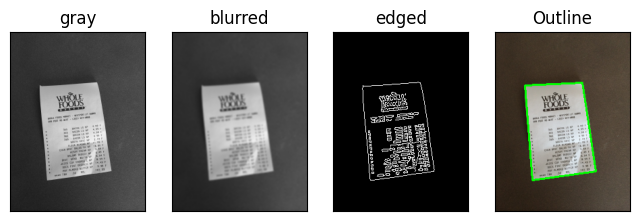

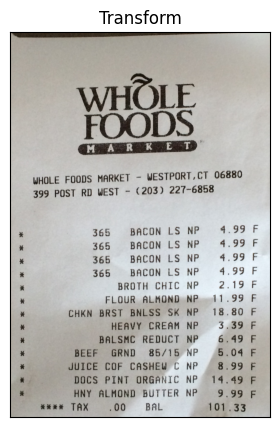

In [6]:
receipt_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

Q. 수정된 이미지로 아래 사항을 적용하여 OCR 수행하세요.
- options = "--psm 4"를 적용하여 pytesseract로 text 변환 및 결과 출력

In [ ]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2GRAY), config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
 

WHOLE
FOODS

WHOLE FOODS MARKET - WESTPORT, CT 06880
399 POST RD WEST - (203) 227-6858

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 4.99
BROTH CHIC NP 4.8

FLOUR ALMOND NP 11.99

CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39

BALSMC REDUCT NP 6.49

BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33





## 이미지 처리 기술과 OpenCV 라이브러리를 사용하여 입력 이미지에서 원하는 텍스트를 추출

- 그림, 표, 바코드 등을 포함한 복잡한 구조의 이미지인 경우에서는 OCR 결과가 좋지 않으며 원하는 영역만 추출하여 OCR을 수행하는 것이 필요

### 이미지 연산을 통한 영역 추출
* 그레이스케일로 변환
* 노이즈를 줄이기 위해 가우시안블러 적용
* 흐릿한 Grayscale 이미지에 blackhat 모폴로지 연산을 적용 (blackhat연산은 밝은 배경(영수증의 배경)에서 어두운 영역(텍스트)을 드러내기 위해 사용됩니다.)
* 닫힘 연산을 통해 끊어져보이는 객체를 연결하여 Grouping합니다.

모폴로지 연산

모폴로지 연산(Morphological operations)은 이미지 처리 분야에서 주로 이진 이미지나 그레이스케일 이미지에 적용되어 구조적 요소를 분석하거나 수정하는 기법입니다. 이 연산은 이미지 내의 형태를 기반으로 처리를 하며, 주로 노이즈 제거, 구조 강조 및 객체 분리와 같은 작업을 위해 사용됩니다. 기본적인 모폴로지 연산에는 팽창(dilation), 침식(erosion), 열림(opening), 닫힘(closing) 등이 있습니다.
- 침식 (Erosion):
침식은 이미지의 경계를 축소시키는 효과를 냅니다. 주어진 구조적 요소를 사용하여 이미지의 각 픽셀에 대해 주변 픽셀을 조사하고, 구조적 요소에 포함된 모든 픽셀이 이미지 내에서 포함되면 그 픽셀을 유지합니다. 그렇지 않으면 제거합니다. 이 과정은 작은 객체를 제거하거나 객체 간 구분을 뚜렷하게 할 때 유용합니다.
- 팽창 (Dilation):
팽창은 침식의 반대 작용으로, 이미지의 경계를 확장합니다. 구조적 요소 내의 어떤 픽셀이라도 원본 이미지와 겹치면, 그 픽셀은 결과 이미지에서 선택됩니다. 이를 통해 구멍을 메우거나 연결되지 않은 객체를 연결할 수 있습니다.
- 열림 (Opening):
열림은 침식 후에 팽창을 수행하는 연산으로, 작은 객체나 돌기를 제거하는 데 효과적입니다. 이 연산은 먼저 노이즈를 제거하고, 그 후 이미지의 크기를 복원합니다.
- 닫힘 (Closing):
닫힘은 팽창 후에 침식을 수행하는 연산으로, 작은 구멍이나 간격을 메우는 데 사용됩니다. 이 연산은 먼저 주요 객체의 연결을 강화하고, 그 후 남은 작은 구멍을 제거합니다.

이러한 모폴로지 연산들은 이미지 분석에서 객체의 기본 형태를 유지하면서 불필요한 노이즈를 제거하거나 객체들을 더 명확하게 분리하는 데 도움을 줍니다. 또한, 다양한 구조적 요소와 파라미터를 조정함으로써 다른 형태와 크기의 객체에 맞게 이 연산들을 맞춤 설정할 수 있습니다.

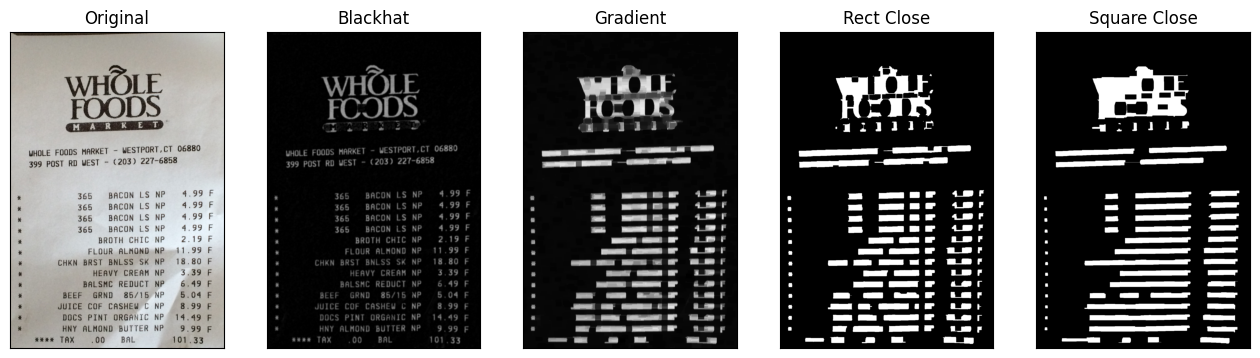

In [ ]:
# 영수증 이미지에서 텍스트 영역을 강조하고 검출하기 위한 이미지 전처리 과정을 구현
gray = cv2.cvtColor(receipt_image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 20)) # 직사각형 모양의 구조 요소를 생성
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 21)) # 더 큰 직사각형 모양의 구조 요소를 생성

gray = cv2.GaussianBlur(gray, (11, 11), 0) # 그레이스케일 이미지에 가우시안 블러를 적용하여 이미지의 잡음을 제거
# 모폴로지 연산 중 하나인 Black Hat 변환을 수행. 이를 통해 이미지에서 어두운 객체나 배경을 찾는다.
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
# Black Hat 이미지에 Sobel 필터를 적용하여 경계를 검출. Sobel 필터는 이미지의 수평 방향 경계를 강조하여 텍스트의 윤곽을 더욱 명확화
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad) # 경계 값을 양수로 만들고
(minVal, maxVal) = (np.min(grad), np.max(grad)) # 정규화
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel) #  이미지에 Closing 연산을 적용
# 이진화를 수행. Otsu의 이진화 기법을 사용하여 임계값을 자동으로 결정
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# 다시 한번 Closing을 수행하여 이진화된 이미지를 더욱 부드럽게 만듭니다.
close_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
# 이진화된 이미지를 침식 연산을 통해 작은 잡음을 제거
close_thresh = cv2.erode(close_thresh, None, iterations=2)
# 원본 이미지와 전처리된 이미지들을 함께 표시
plt_imshow(["Original", "Blackhat", "Gradient", "Rect Close", "Square Close"], [receipt_image, blackhat, grad, thresh, close_thresh], figsize=(16, 10))

Grouping된 이미지를 좀 더 크게 보면 아래와 같습니다.

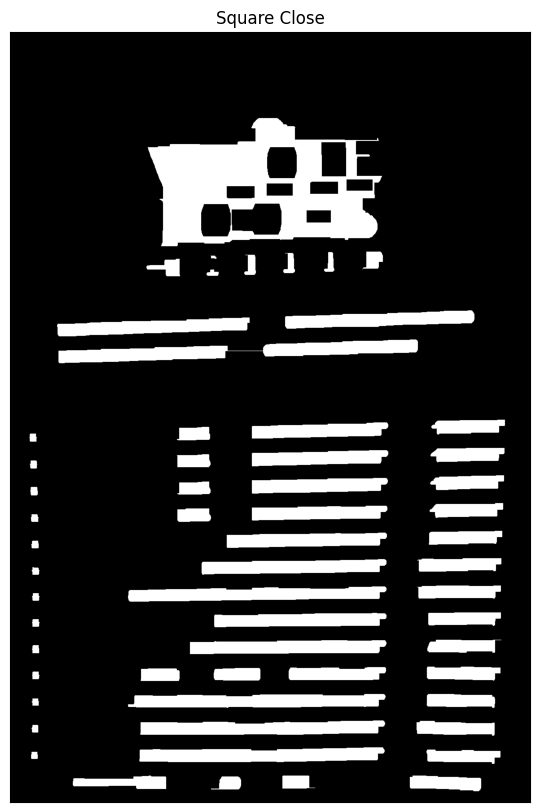

In [ ]:
plt_imshow(["Square Close"], [close_thresh], figsize=(16, 10))

Grouping 된 영역의 윤곽선을 찾고 그 윤곽선이 특정 조건 (Ex. 종횡비 등)에 만족하는 영역만 추출합니다.

In [ ]:
# 바깥쪽 컨투어만 찾도록 지정하고, 컨투어를 근사화하여 저장
cnts = cv2.findContours(close_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# 컨투어 리스트를 가져오고 imutils 라이브러리를 사용하여 호환성을 높입니다.
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0] # 컨투어를 상하 방향으로 정렬

roi_list = []
roi_title_list = []

margin = 20
receipt_grouping = receipt_image.copy()

for c in cnts:
  (x, y, w, h) = cv2.boundingRect(c) # 각 컨투어를 둘러싸는 최소 크기의 사각형(바운딩 박스)를 계산
  ar = w // float(h) # 사각형의 가로 세로 비율
  # 사각형의 가로 세로 비율이 3.0에서 6.5 사이에 있고, 이미지의 가운데보다 오른쪽에 위치한 경우
  if ar > 3.0 and ar < 6.5 and (W/2) < x:
    color = (0, 255, 0)
    # 원본 이미지 receipt_image에서 지정된 사각형 영역을 포함하고, 그 주변에 margin만큼의 여백을 추가한 영역을 추출
    roi = receipt_image[y - margin:y + h + margin, x - margin:x + w + margin]
    roi_list.append(roi)
    roi_title_list.append("Roi_{}".format(len(roi_list)))
  else:
    color = (0, 0, 255)

  cv2.rectangle(receipt_grouping, (x - margin, y - margin), (x + w + margin, y + h + margin), color, 2)
  cv2.putText(receipt_grouping, "".join(str(ar)), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, color, 2)

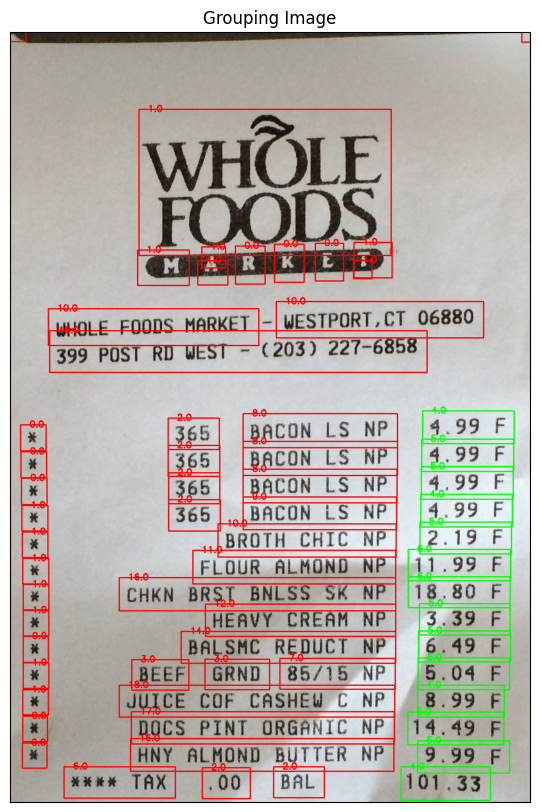

In [ ]:
plt_imshow(["Grouping Image"], [receipt_grouping], figsize=(16, 10))

찾은 영역을 아래와 같으며 각 이미지를 OCR 수행

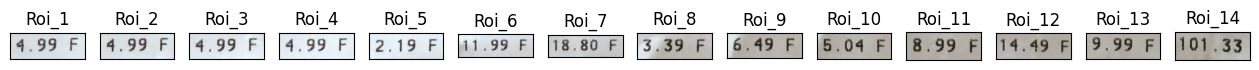

4.99 F

4.99 F

4.99 F

4.99 F

2.19 F

11.99 F

18.80 F

3.39 F

6.49 F

5.04 F

8.99 F

14.49 F

9.99 F

101.33



In [ ]:
plt_imshow(roi_title_list, roi_list, figsize=(16, 10))

for roi in roi_list:
  gray_roi= cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
  threshold_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  roi_text = pytesseract.image_to_string(threshold_roi)
  print(roi_text)

추출된 이미지만큼 OCR을 수행하면 성능이 많이 느리기때문에 이미지를 Merge하여 OCR 횟수를 최소화.

In [ ]:
#  이미지를 주어진 행(row)과 열(col) 크기로 조정하고, 필요에 따라 이미지 주변에 흰색 바탕을 추가하여 변형
def mergeResize(img, row=300, col=200):
    IMG_COL = col #66

    # row값에 따른 col값 변경. 이미지의 비율을 유지하면서 크기를 조정
    IMG_COL = int((row * IMG_COL)/row)

    IMG_ROW = row
    border_v = 0
    border_h = 0

    if (IMG_COL / IMG_ROW) >= (img.shape[0] / img.shape[1]):
        border_v = int((((IMG_COL / IMG_ROW) * img.shape[1]) - img.shape[0]) / 2)
    else:
        border_h = int((((IMG_ROW / IMG_COL) * img.shape[0]) - img.shape[1]) / 2)
    img = cv2.copyMakeBorder(img, top=border_v, bottom=border_v, left=0, right=border_h + border_h, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    img = cv2.resize(img, (IMG_ROW, IMG_COL))
    return img

In [ ]:
for idx, roi in enumerate(roi_list):
  if idx == 0:
    mergeImg = mergeResize(roi)
  else:
    cropImg = mergeResize(roi) # 각 이미지는 동일하게 mergeResize 함수를 통해 조정
    # 현재 처리된 cropImg를 이전에 처리된 이미지들이 저장된 mergeImg에 세로 방향(axis=0)으로 병합
    mergeImg = np.concatenate((mergeImg, cropImg), axis=0)

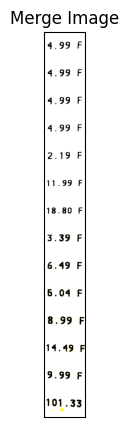

11.99 F
18.80 F
3.39 F
6.49 F
5.04 F
8.99 F
14.49 F
9.99 F

101.33



In [ ]:
# cv2.threshold 함수는 OpenCV에서 제공하는 이미지 이진화를 위한 함수 중 하나
threshold_mergeImg = cv2.threshold(mergeImg, 150, 255, cv2.THRESH_BINARY)[1] # 150 임계값, 두번째 반환값은 이진화된 이미지
plt_imshow(["Merge Image"], [threshold_mergeImg])
merge_Img_text = pytesseract.image_to_string(threshold_mergeImg)
print(merge_Img_text)

## 정규식을 통한 영역 추출

In [15]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB), config=options)

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
 

WHOLE
FOODS

WHOLE FOODS MARKET - WESTPORT, CT 06880
399 POST RD WEST ~- (203) 227-6858

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 99

365 BACON LS NP 4.99
BROTH CHIC NP rae

FLOUR ALMOND NP 11.99

CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39

BALSMC REDUCT NP 6.49

BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33





전화번호만 출력

In [8]:
phoneNums = re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', text)

# phoneNums = re.findall(r'\(\d{3}\) \d{3}-\d{4}', text)
phoneNums

['(203) 227-6858']

- r": 이는 raw string 표기법. raw string을 사용하면 문자열 안에서 백슬래시를 이스케이프 문자로 사용하지 않고 그대로 표현. 일반 문자열에서는 \.를 표현하려면 \\.라고 써야 합니다. 왜냐하면 Python의 문자열 파싱 과정에서 첫 번째 백슬래시가 두 번째 백슬래시를 이스케이프 처리하기 때문입니다. 그러나 raw string에서는 이스케이프 처리가 발생하지 않기 때문에 \.가 정규 표현식에서 리터럴 점(.)을 매치하는 것으로 직접 사용
- (?: ... )는 non-capturing group을 의미. 이 그룹은 매치되어야 하지만, 결과로써 추출되거나 반환되지는 않는다.

Q. text에서 가격만 추출하여 출력하세요.

In [16]:
prices = re.findall(r"NP (\d+\.\d{2})", text)
# prices = re.findall(r"(?:NP) (\d+\.\d{2})", text)
prices

['4.99',
 '4.99',
 '4.99',
 '11.99',
 '18.80',
 '3.39',
 '6.49',
 '5.04',
 '8.99',
 '14.49',
 '9.99']

Q. text에서 합산 가격만 추출하여 출력하세요.

In [17]:
total_price = re.findall(r"BAL (\d+\.\d{2})", text)
total_price

['101.33']

정규식은 명함과 같은 이미지 OCR에 활용하면 좋다.

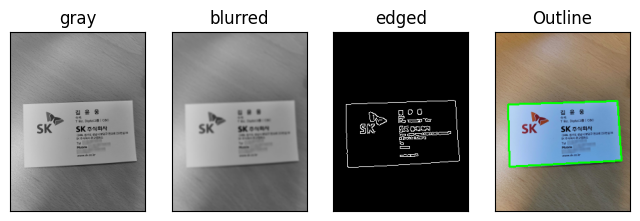

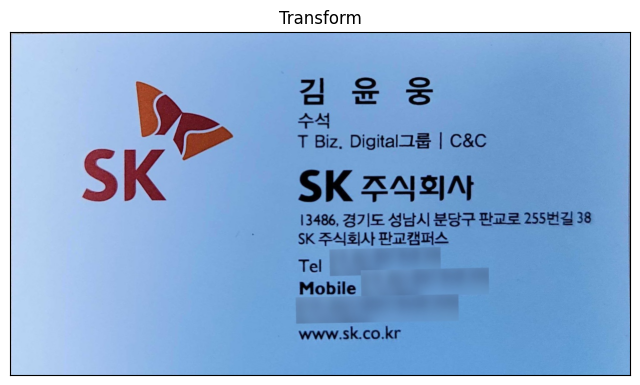

In [18]:
url = 'https://user-images.githubusercontent.com/69428232/155486780-55525c3c-8f5f-4313-8590-dd69d4ce4111.jpg'

image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)

business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [19]:
options = "--psm 4"
text = pytesseract.image_to_string(business_card_image, config=options, lang='kor+eng')

# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
oS  So
김 윤 웅
수석
T Biz. Digital | C&C

SK 2413)4t

13486, 경기도 성남시 분당구 판교로 255번길 38
< 주식회사 판교캠퍼스

Tel
Mobile

www.sk.co.kr





Q. 정규표현식을 이용하여 아래와 같이 출력하세요.

```
유선전화 : 정보 없음
휴대전화 : 정보 없음
이메일 : 정보 없음
주소 : 13486, 경기도 성남시 분당구 판교로 255번길 38
```

In [20]:
tel_matches = re.findall(r'(?:Tel )([\+\(]?[0-9][0-9 .\-\(\)]{8,}[0-9])', text)
mobile_matches = re.findall(r'(?:Mobile )([\+\(]?[0-9][0-9 .\-\(\)]{8,}[0-9])', text)
email_matches = re.findall(r"[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+", text)
addr_matches = re.findall(r"[0-9\.\-+_]+\,.*", text)

# 첫 번째 매치 결과 사용 또는 기본값 사용
tel = tel_matches[0] if tel_matches else "정보 없음"
mobile = mobile_matches[0] if mobile_matches else "정보 없음"
emails = email_matches[0] if email_matches else "정보 없음"
addr = addr_matches[0] if addr_matches else "정보 없음"

print("유선전화 : {}".format(tel))
print("휴대전화 : {}".format(mobile))
print("이메일 : {}".format(emails))
print("주소 : {}".format(addr))

유선전화 : 정보 없음
휴대전화 : 정보 없음
이메일 : 정보 없음
주소 : 13486, 경기도 성남시 분당구 판교로 255번길 38
